In [66]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from bci_aic3.paths import PROCESSED_DATA_DIR
from bci_aic3.train import create_processed_data_loaders


In [67]:
train, val = create_processed_data_loaders(
    processed_data_dir=PROCESSED_DATA_DIR,
    task_type="MI",
    batch_size=64,
    num_workers=6,
)

In [72]:
from scipy.signal import welch
from scipy.linalg import eigh
from sklearn.base import BaseEstimator, TransformerMixin

class CSP(BaseEstimator, TransformerMixin):
    """
    Common Spatial Pattern (CSP) transformer.

    This transformer learns spatial filters that maximize the variance 
    for one class and minimize it for the other in a 2-class scenario.

    Parameters
    ----------
    n_components : int, default=4
        The number of spatial filters to keep. This should be an even number,
        as half of the filters will be for one class and half for the other.
    """
    def __init__(self, n_components=4):
        self.n_components = n_components
        self.filters_ = None

    def fit(self, X, y):
        """
        Fit the CSP filters.

        Parameters
        ----------
        X : np.ndarray, shape (n_trials, n_channels, n_timepoints)
            The EEG data.
        y : np.ndarray, shape (n_trials,)
            The class labels for each trial.
        """
        # Ensure X is a 3D array
        if X.ndim != 3:
            raise ValueError("X must be a 3D array of shape (n_trials, n_channels, n_timepoints).")
        
        n_trials, n_channels, n_timepoints = X.shape
        
        # Get the unique classes
        classes = np.unique(y)
        if len(classes) != 2:
            raise ValueError("CSP is designed for 2-class problems.")
        
        # Calculate the covariance matrices for each class
        # Note: A common way is to concatenate all trials of a class and compute a single covariance
        X_class1 = X[y == classes[0]]
        X_class2 = X[y == classes[1]]

        # Reshape to (n_channels, n_trials * n_timepoints) for covariance calculation
        cov_class1 = np.cov(X_class1.reshape(X_class1.shape[1], -1))
        cov_class2 = np.cov(X_class2.reshape(X_class2.shape[1], -1))
        
        # Normalize by trace to avoid numerical issues
        cov_class1 /= np.trace(cov_class1)
        cov_class2 /= np.trace(cov_class2)

        # Solve the generalized eigenvalue problem: C1 * W = lambda * (C1 + C2) * W
        eigenvalues, eigenvectors = eigh(cov_class1, cov_class1 + cov_class2)
        
        # Sort eigenvalues in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        
        # Select the top and bottom filters
        # Top filters maximize variance for class 1
        # Bottom filters maximize variance for class 2
        top_indices = sorted_indices[:self.n_components // 2]
        bottom_indices = sorted_indices[-(self.n_components // 2):]
        
        self.filters_ = eigenvectors[:, np.hstack([top_indices, bottom_indices])].T
        
        return self

    def transform(self, X):
        """
        Apply the learned spatial filters to the data.

        Parameters
        ----------
        X : np.ndarray, shape (n_trials, n_channels, n_timepoints)
            The EEG data.

        Returns
        -------
        X_transformed : np.ndarray, shape (n_trials, n_components, n_timepoints)
            The data transformed by the CSP filters.
        """
        if self.filters_ is None:
            raise RuntimeError("The CSP transformer has not been fitted yet.")
        
        # Apply filters using Einstein summation for efficiency
        # 'ik,tkl->til' means: for each trial t, multiply filters (ik) with data (kl)
        # i = n_components, k = n_channels, t = n_trials, l = n_timepoints
        return np.einsum('ik,tkl->til', self.filters_, X)


class LogVarTransformer(BaseEstimator, TransformerMixin):
    """
    Computes the log-variance of the input data along the last axis.
    This is typically used after a CSP transformation.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Parameters
        ----------
        X : np.ndarray, shape (n_trials, n_components, n_timepoints)
            The data after CSP transformation.

        Returns
        -------
        np.ndarray, shape (n_trials, n_components)
            The log-variance features.
        """
        # Calculate variance along the timepoints axis (last axis)
        # Adding a small epsilon to avoid log(0)
        return np.log(np.var(X, axis=-1) + 1e-9)


class BandPowerTransformer(BaseEstimator, TransformerMixin):
    """
    Computes band power features from EEG data.
    
    Parameters
    ----------
    sfreq : int
        The sampling frequency of the data.
    bands : dict
        A dictionary where keys are band names and values are tuples (low_freq, high_freq).
        Example: {'alpha': (8, 12), 'beta': (13, 30)}
    nperseg : int, default=None
        Length of each segment for Welch's method. Defaults to sfreq.
    """
    def __init__(self, sfreq, bands, nperseg=None):
        self.sfreq = sfreq
        self.bands = bands
        self.nperseg = nperseg if nperseg is not None else sfreq

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Parameters
        ----------
        X : np.ndarray, shape (n_trials, n_channels, n_timepoints)
            The EEG data.

        Returns
        -------
        features : np.ndarray, shape (n_trials, n_channels * n_bands)
            The extracted band power features.
        """
        n_trials, n_channels, _ = X.shape
        n_bands = len(self.bands)
        
        features = np.zeros((n_trials, n_channels * n_bands))
        
        for trial_idx in range(n_trials):
            trial_features = []
            for channel_idx in range(n_channels):
                # Calculate Power Spectral Density (PSD) using Welch's method
                freqs, psd = welch(X[trial_idx, channel_idx, :], self.sfreq, nperseg=self.nperseg)
                
                channel_band_powers = []
                for band_name, (low, high) in self.bands.items():
                    # Find frequency indices corresponding to the band
                    band_mask = (freqs >= low) & (freqs <= high)
                    # Compute power by summing the PSD values in the band
                    band_power = np.sum(psd[band_mask])
                    channel_band_powers.append(band_power)
                
                trial_features.extend(channel_band_powers)
            
            features[trial_idx, :] = np.array(trial_features)
            
        return features


In [92]:
# Extract numpy arrays from train DataLoader only
def dataloader_to_numpy(dataloader):
    X_list, y_list = [], []
    for X_batch, y_batch in dataloader:
        X_list.append(X_batch.numpy())
        y_list.append(y_batch.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X, y = dataloader_to_numpy(train)


In [93]:
X = X[:,0,:,:]
X.shape, y.shape


((2400, 8, 1500), (2400,))

In [103]:
# 2. Define the cross-validation strategy
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- PIPELINE 1: CSP + LogVar + LDA ---
print("--- Testing Pipeline with CSP + Log-Variance ---")

# Create the scikit-learn pipeline
csp_pipeline = Pipeline([
    ('csp', CSP(n_components=6)),
    ('logvar', LogVarTransformer()),
    ('scaler', StandardScaler()), # It's good practice to scale features
    ('clf', SVC(kernel="rbf",C=1, gamma="auto"))
])

--- Testing Pipeline with CSP + Log-Variance ---


In [104]:
# Run cross-validation
csp_scores = cross_val_score(csp_pipeline, X, y, cv=cv, n_jobs=-1)

print(f"CSP + LDA Cross-validation scores: {csp_scores}")
print(f"Mean CV Score: {np.mean(csp_scores):.4f} (+/- {np.std(csp_scores):.4f})\n")

CSP + LDA Cross-validation scores: [0.48958333 0.5375     0.50833333 0.5375     0.50833333]
Mean CV Score: 0.5162 (+/- 0.0187)



In [109]:
# --- PIPELINE 2: Band Power + LDA ---
print("--- Testing Pipeline with Band Power Features ---")

# Define frequency bands of interest for motor imagery
bands = {
    'mu': (8, 12),
    'beta': (13, 30)
}

bandpower_pipeline = Pipeline([
    ('bandpower', BandPowerTransformer(sfreq=250, bands=bands)),
    ('scaler', StandardScaler()),
    ('clf', LinearDiscriminantAnalysis())
])

--- Testing Pipeline with Band Power Features ---


In [111]:

# Run cross-validation
bandpower_scores = cross_val_score(bandpower_pipeline, X, y, cv=cv, n_jobs=-1)

print(f"Band Power + LDA Cross-validation scores: {bandpower_scores}")
print(f"Mean CV Score: {np.mean(bandpower_scores):.4f} (+/- {np.std(bandpower_scores):.4f})")

Band Power + LDA Cross-validation scores: [0.52291667 0.49375    0.48958333 0.50625    0.52291667]
Mean CV Score: 0.5071 (+/- 0.0140)


In [102]:
# X should be your data, y the labels
X_flattened = X.reshape(X.shape[0], -1)  # Flatten channels and time


In [112]:
# Dummy Classifier (your current baseline)
dummy = DummyClassifier(strategy="most_frequent")
scores_dummy = cross_val_score(dummy, X_flattened, y, cv=StratifiedKFold(5))
print(f"Dummy Classifier Accuracy: {np.mean(scores_dummy):.3f}")  # Should be ~0.50


Dummy Classifier Accuracy: 0.505


In [ ]:
# A simple but effective EEG baseline (LDA)
lda_pipeline = make_pipeline(LinearDiscriminantAnalysis())
scores_lda = cross_val_score(lda_pipeline, X_flattened, y, cv=StratifiedKFold(5), n_jobs=-1)
print(f"LDA Accuracy: {np.mean(scores_lda):.3f}")

In [62]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_theme()
%matplotlib inline

In [63]:
from bci_aic3.config import load_processing_config
from bci_aic3.paths import MI_CONFIG_PATH


processing_config = load_processing_config(MI_CONFIG_PATH)

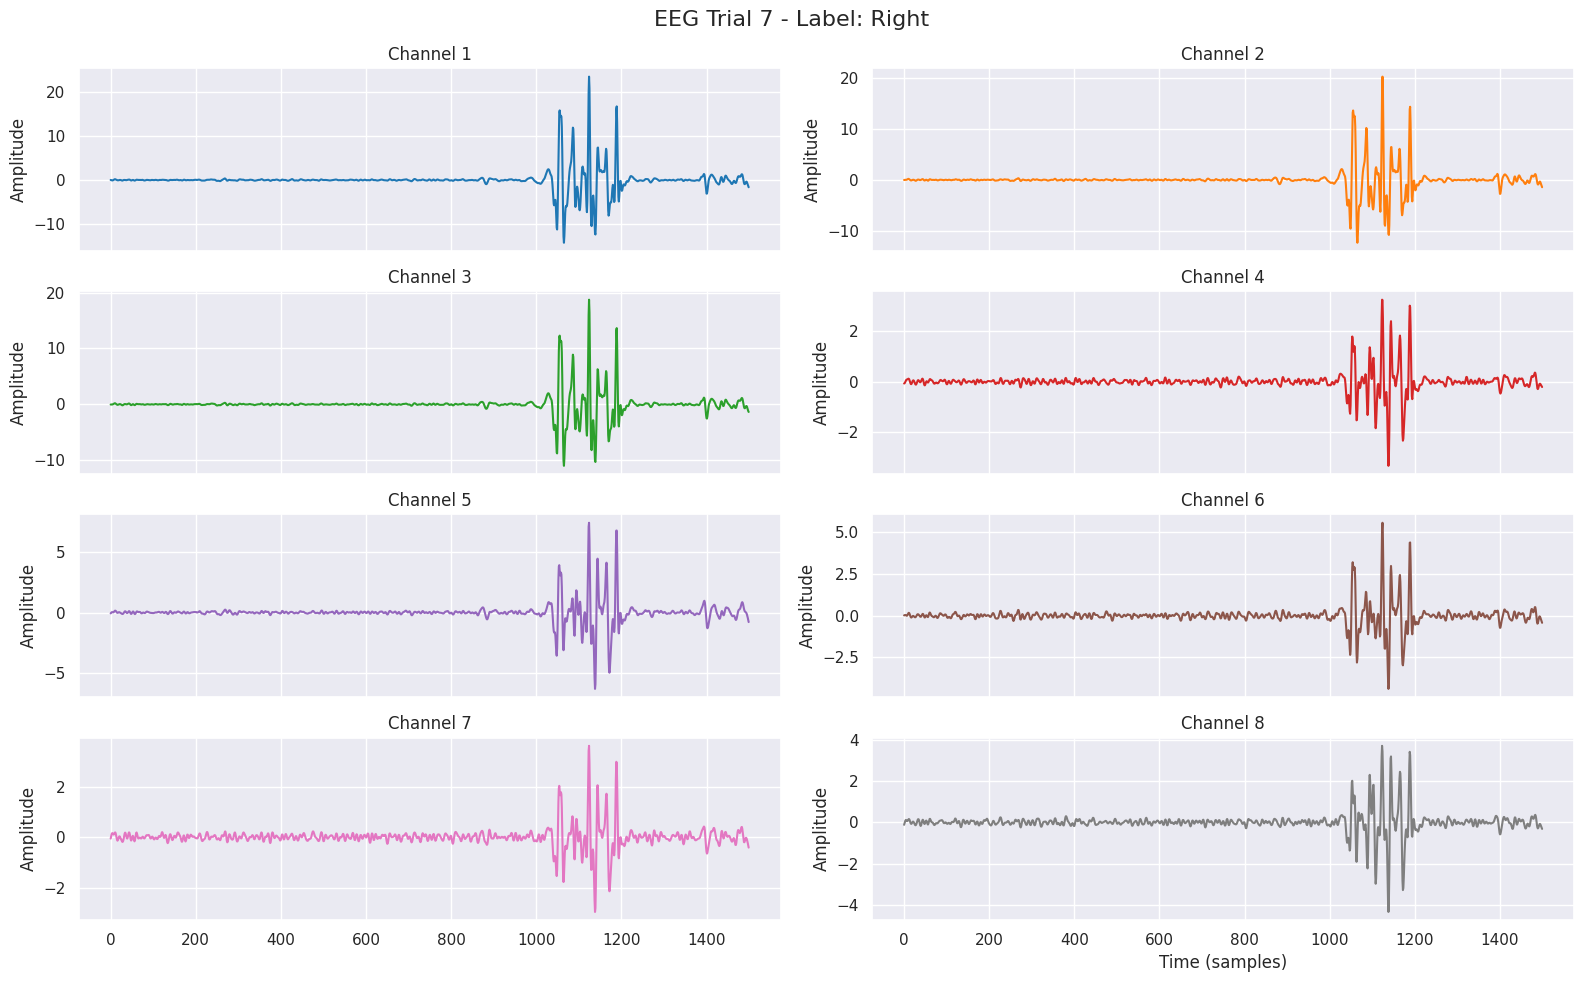

In [64]:
from bci_aic3.paths import REVERSE_LABEL_MAPPING_PATH
from bci_aic3.util import read_json_to_dict

reverse_label_mapping = read_json_to_dict(REVERSE_LABEL_MAPPING_PATH)

trial = 7
fig, axes = plt.subplots(4, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()
time = np.arange(X.shape[3])

fig.suptitle(
    f"EEG Trial {trial} - Label: {reverse_label_mapping[str(y[trial])]}",
    fontsize=16,
)
(X[trial])
for ch in range(8):
    axes[ch].plot(time, X[trial, 0, ch], color=plt.cm.tab10(ch))
    axes[ch].set_title(f"Channel {ch + 1}")
    axes[ch].set_ylabel("Amplitude")
    axes[ch].grid(True)

axes[-1].set_xlabel("Time (samples)")
plt.tight_layout()
plt.show()

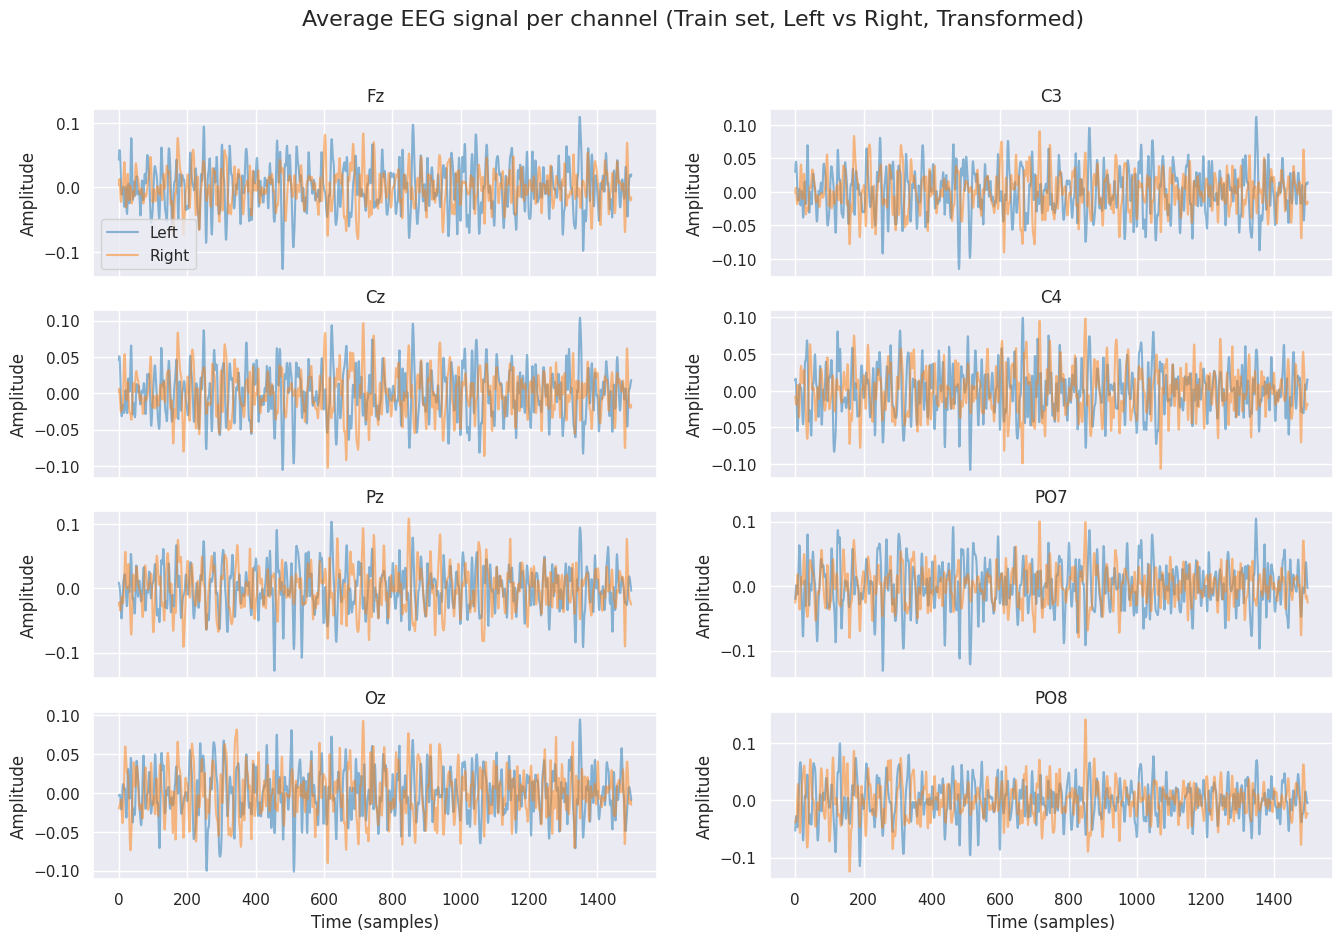

In [65]:
labels_to_plot = [0, 1]
label_names = [reverse_label_mapping[str(l)] for l in labels_to_plot]

fig, axes = plt.subplots(4, 2, figsize=(16, 10), sharex=True)
fig.suptitle(
    "Average EEG signal per channel (Train set, Left vs Right, Transformed)",
    fontsize=16,
)
axes = axes.flatten()
time = np.arange(X.shape[3])
train_labels_copy = y

for ch in range(8):
    for label, color in zip(labels_to_plot, ["tab:blue", "tab:orange"]):
        mask = train_labels_copy == label
        avg_signal = X[mask,0, ch].mean(axis=0)
        axes[ch].plot(time, avg_signal, label=label_names[label], color=color, alpha=0.5)
    axes[ch].set_title(f"{processing_config.ch_names[ch]}")
    axes[ch].set_ylabel("Amplitude")
    axes[ch].grid(True)
    if ch == 0:
        axes[ch].legend()

axes[-1].set_xlabel("Time (samples)")
axes[-2].set_xlabel("Time (samples)");